In [1]:
using ITensors, ITensorMPS
using LinearAlgebra
using SparseArrays
using Plots
using JLD2

In [2]:
include("src/main.jl")
include("src/observables.jl")
include("src/states.jl")
include("src/doubled_measurements.jl")

forced_doubled_measure_with_val (generic function with 2 methods)

In [3]:
function MPS_update_data(ρ::MPS, observables::Vector{Symbol}, data::Dict{Symbol,Vector{Float64}}, t::Int; ref=false)
    if :Ic in observables
        data[:Ic][t] = Ic2(ρ)
    end
    if :SR in observables
        data[:SR][t] = SR(ρ)
    end
    if :κEA in observables
        data[:κEA][t] = κEA(ρ; ref=ref)
    end
    if :κ2 in observables
        data[:κ2][t] = κ2(ρ; ref=ref)
    end
    if :maxlinkdim in observables
        data[:maxlinkdim][t] = maxlinkdim(ρ)
    end
    return data
end

MPS_update_data (generic function with 1 method)

In [4]:
ρ, sites = ghz(2)
bell_state = bell(sites)

ρ, _, _ = doubled_measure(ρ, PauliX, 1.0, 1:2; ref=false)
ρ /= inner(bell_state, ρ)
truncate!(ρ; cutoff=1E-8, maxdim=200)

ρ, _, _ = doubled_measure(ρ, kron(PauliZ,PauliZ), 1.0, 1:1; ref=false)
ρ /= inner(bell_state, ρ)
truncate!(ρ; cutoff=1E-8, maxdim=200)

to_matrix(ρ)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.5+0.0im  0.5+0.0im  0.0+0.0im
 0.0+0.0im  0.5+0.0im  0.5+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [28]:
ρ, sites = ghz(3; ref=true)
κ2(ρ; ref=true)

3.0

In [71]:
L = 4
T = 2L
λ = 0.5
δ = 0.7
q = 0.2
samples = 100
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
foo = sample(L, T, λ, δ, q, samples; observables=observables)
foo[:κEA][end]

2.517668415924612

In [72]:
L = 8
T = 2L
λ = 0.5
δ = 0.7
q = 0.2
samples = 100
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
foo = sample(L, T, λ, δ, q, samples; observables=observables)
foo[:κEA][end]

3.502679650478852

In [74]:
L = 12
T = 2L
λ = 0.5
δ = 0.7
q = 0.2
samples = 10
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
foo12 = sample(L, T, λ, δ, q, samples; observables=observables)
foo12[:κEA][end]

3.5102747653798643

In [131]:
jldsave("25_07_16_small_fig_5_data.jld2"; data3)

In [98]:
function circuit(L::Int, T::Int, Δ::Float64, δ::Float64, q::Float64; observables=Symbol[], cutoff=1E-8, maxdim=200)
    ρ, sites = ghz(L; ref=true)

    data = Dict([s => zeros(Float64, 2T+2) for s in observables])
    data = MPS_update_data(ρ, observables, data, 1; ref=true)
    data = MPS_update_data(ρ, observables, data, 2; ref=true)

    λzz = δ*sqrt( (1-Δ)/2 )
    λx = δ*sqrt( (1+Δ)/2 )

    Xn = decoherence_layer(sites, PauliX, q, 1:L, L)
    ZZn = decoherence_layer(sites, kron(PauliZ, PauliZ), q, 1:L-1, L)
    bell_state = bell(sites)


    for t in 1:T
        ρ, _, _ = doubled_measure(ρ, PauliX, λx, 1:L; ref=true)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        ρ = apply(Xn, ρ)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        data = MPS_update_data(ρ, observables, data, 2t+1; ref=true)

        ρ, _, _ = doubled_measure(ρ, kron(PauliZ,PauliZ), λzz, 1:L-1; ref=true)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        ρ = apply(ZZn, ρ)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        data = MPS_update_data(ρ, observables, data, 2t+2; ref=true)
    end

    return ρ, data
end

circuit (generic function with 1 method)

In [99]:
function sample(L::Int, T::Int, Δ::Float64, δ::Float64, q::Float64, samples::Int; observables=Symbol[], cutoff=1E-8, maxdim=200)
    mean_data = Dict([s => zeros(Float64, 2T+2) for s in observables])
    for _ in 1:samples
        _, sample_data = circuit(L, 2L, Δ, δ, q; observables=observables)
        for observable in observables
            mean_data[observable] += sample_data[observable]
        end
    end
    for observable in observables
        mean_data[observable] /= samples
    end
    return mean_data
end

sample (generic function with 1 method)

In [137]:
L = 4
sample(L, 2L, -0.5, 0.7, 0.1, 100; observables=Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim])[:Ic][end]

0.07253995846965058

In [139]:
L = 8
sample(L, 2L, -0.5, 0.7, 0.1, 10; observables=Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim])[:Ic][end]

0.07408868185710128

In [141]:
L = 12
sample(L, 2L, -0.5, 0.7, 0.1, 10; observables=Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim])[:Ic][end]

0.03800044560171654

In [ ]:
# data3 = Dict{Tuple{Int, Int, Float64, Float64, Float64},Tuple{Int,Dict}}()

Dict{Tuple{Int64, Int64, Float64, Float64, Float64}, Tuple{Int64, Dict}}()

In [ ]:
# observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
# samples = 250
# # λ = 0.1
# δ = 0.7
# # q = 0.1

# # observables = Symbol[:maxlinkdim]

# for q in [0.1]
#     for Δ in -1.0:0.25:1.0
#         for L in 4:4:12
#             T = 2L
#             data3[(L,T,Δ,δ,q)] = (samples, sample(L, T, Δ, δ, q, samples; observables=observables))
#         end
#     end
# end

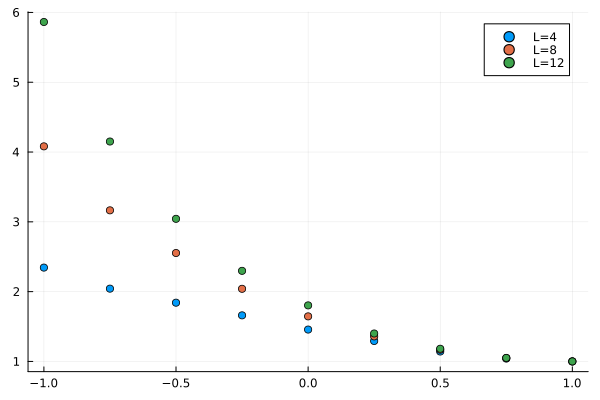

In [129]:

δ = 0.7
q = 0.1

observable  = :κEA

plt = plot()
for L in 4:4:12
    xs = -1.0:0.25:1.0
    ys = [(data3[(L,2L,Δ,δ,q)][2][observable][end-1]+data3[(L,2L,Δ,δ,q)][2][observable][end])/2 for Δ in xs]
    plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
end
plt

In [49]:
L = 8
λ = 0.0
δ = 0.7
q = 0.1
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]

ρ, data = circuit(L, 2L, λ, δ, q; observables=observables)

(MPS
[1] ((dim=2|id=512|"Qubit,Site,n=1"), (dim=2|id=526|"Link,l=1"))
[2] ((dim=2|id=625|"Qubit,Site,n=2"), (dim=4|id=1|"Link,l=2"), (dim=2|id=526|"Link,l=1"))
[3] ((dim=2|id=895|"Qubit,Site,n=3"), (dim=4|id=514|"Link,l=3"), (dim=4|id=1|"Link,l=2"))
[4] ((dim=2|id=62|"Qubit,Site,n=4"), (dim=4|id=362|"Link,l=4"), (dim=4|id=514|"Link,l=3"))
[5] ((dim=2|id=13|"Qubit,Site,n=5"), (dim=4|id=229|"Link,l=5"), (dim=4|id=362|"Link,l=4"))
[6] ((dim=2|id=180|"Qubit,Site,n=6"), (dim=4|id=154|"Link,l=6"), (dim=4|id=229|"Link,l=5"))
[7] ((dim=2|id=300|"Qubit,Site,n=7"), (dim=8|id=664|"Link,l=7"), (dim=4|id=154|"Link,l=6"))
[8] ((dim=2|id=913|"Qubit,Site,n=8"), (dim=8|id=476|"Link,l=8"), (dim=8|id=664|"Link,l=7"))
[9] ((dim=2|id=309|"Qubit,Site,n=9"), (dim=8|id=538|"Link,l=9"), (dim=8|id=476|"Link,l=8"))
[10] ((dim=2|id=726|"Qubit,Site,n=10"), (dim=8|id=936|"Link,l=10"), (dim=8|id=538|"Link,l=9"))
[11] ((dim=2|id=26|"Qubit,Site,n=11"), (dim=12|id=273|"Link,l=11"), (dim=8|id=936|"Link,l=10"))
[12] ((di

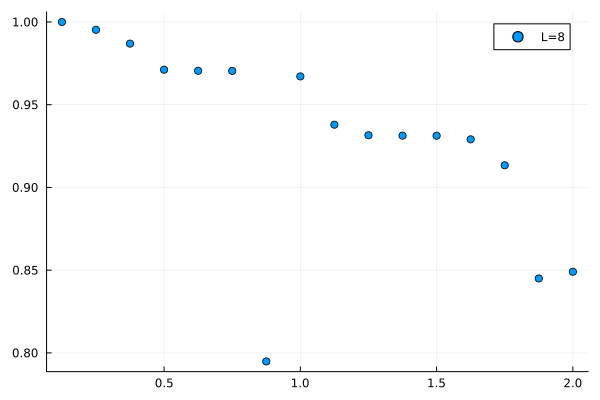

In [50]:

plt = plot()
for L in [8]
    xs = collect(1:2L)/L
    ys = data[:Ic]
    plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
end
plt

In [53]:
function sample(L::Int, T::Int, λ::Float64, δ::Float64, q::Float64, samples::Int; observables=Symbol[], cutoff=1E-8, maxdim=200)
    mean_data = Dict([s => zeros(Float64, T+1) for s in observables])
    for _ in 1:samples
        _, sample_data = circuit(L, 2L, λ, δ, q; observables=observables)
        for observable in observables
            mean_data[observable] += sample_data[observable]
        end
    end
    for observable in observables
        mean_data[observable] /= samples
    end
    return mean_data
end

sample (generic function with 1 method)

In [54]:
data = Dict{Tuple{Int, Int, Float64, Float64, Float64},Tuple{Int,Dict}}()

Dict{Tuple{Int64, Int64, Float64, Float64, Float64}, Tuple{Int64, Dict}}()

In [95]:
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
samples = 100
λ = 1.0
δ = 1.0
q = 0.1

# observables = Symbol[:maxlinkdim]

for L in [10]
    T = 2L
    data[(L,T,λ,δ,q)] = (samples, sample(L, T, λ, δ, q, samples; observables=observables))
end

In [ ]:
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
samples = 100
# λ = 0.1
δ = 0.5
# q = 0.1

# observables = Symbol[:maxlinkdim]

for q in [0.1]
    for λ in 0.0:0.2:1.0
        for L in 4:4:8
            T = 2L
            data[(L,T,λ,δ,q)] = (samples, sample(L, T, λ, δ, q, samples; observables=observables))
        end
    end
end

In [76]:
# λ = 1.0
# δ = 1.0
# q = 0.1

# plt = plot()
# for L in [10]
#     xs = collect(1:2L)/L
#     ys = data[(L,2L,λ,δ,q)][2][:SR]
#     plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
# end
# plt

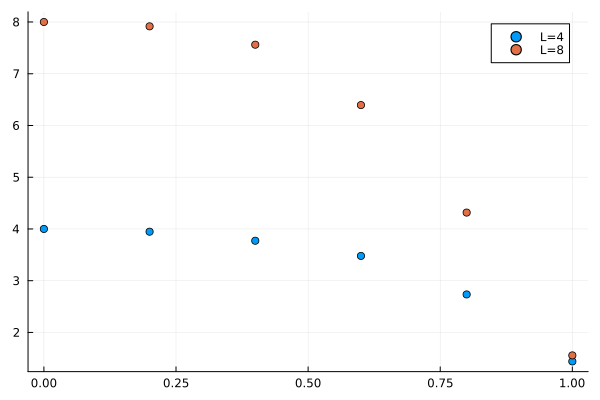

In [80]:

δ = 0.7
q = 0.1

plt = plot()
for L in 4:4:8
    xs = 0.0:0.2:1.0
    ys = [data[(L,2L,λ,δ,q)][2][:κ2][end] for λ in xs]
    plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
end
plt

In [11]:
ρ

MPS
[1] ((dim=2|id=318|"Qubit,Site,n=1"), (dim=2|id=431|"Link,l=1"))
[2] ((dim=2|id=281|"Qubit,Site,n=2"), (dim=4|id=273|"Link,l=2"), (dim=2|id=431|"Link,l=1"))
[3] ((dim=2|id=947|"Qubit,Site,n=3"), (dim=8|id=127|"Link,l=3"), (dim=4|id=273|"Link,l=2"))
[4] ((dim=2|id=820|"Qubit,Site,n=4"), (dim=13|id=516|"Link,l=4"), (dim=8|id=127|"Link,l=3"))
[5] ((dim=2|id=364|"Qubit,Site,n=5"), (dim=8|id=352|"Link,l=5"), (dim=13|id=516|"Link,l=4"))
[6] ((dim=2|id=466|"Qubit,Site,n=6"), (dim=13|id=942|"Link,l=6"), (dim=8|id=352|"Link,l=5"))
[7] ((dim=2|id=333|"Qubit,Site,n=7"), (dim=8|id=250|"Link,l=7"), (dim=13|id=942|"Link,l=6"))
[8] ((dim=2|id=338|"Qubit,Site,n=8"), (dim=15|id=810|"Link,l=8"), (dim=8|id=250|"Link,l=7"))
[9] ((dim=2|id=171|"Qubit,Site,n=9"), (dim=8|id=649|"Link,l=9"), (dim=15|id=810|"Link,l=8"))
[10] ((dim=2|id=744|"Qubit,Site,n=10"), (dim=15|id=63|"Link,l=10"), (dim=8|id=649|"Link,l=9"))
[11] ((dim=2|id=438|"Qubit,Site,n=11"), (dim=12|id=791|"Link,l=11"), (dim=15|id=63|"Link,l=10"